In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap
import os

In [48]:
def visualize_embedding_evolution(embeddings_list, labels, method='PCA', class_names=None, colors=None):
    """
    Visualize the evolution of embeddings over time with arrows.

    Parameters:
    - embeddings_list: List of numpy arrays, each of shape (n_samples, n_features),
                       representing embeddings at different TTT stages.
    - labels: Array of shape (n_samples,) representing class labels.
    - class_names: Optional; List of class names corresponding to unique labels.
    - colors: Optional; List of colors for each class.

    Returns:
    - A matplotlib figure showing the embedding evolution.
    """
    assert len(embeddings_list) > 1, "At least two embedding stages are required for visualization."
    assert all(emb.shape[0] == len(labels) for emb in embeddings_list), "All embeddings must match the number of samples."

    # Perform PCA on the combined embeddings from all stages to ensure consistent projection
    combined_embeddings = np.vstack(embeddings_list)
    if method == 'PCA':
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(combined_embeddings)
    elif method == 't-SNE':
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(combined_embeddings)
    elif method == 'UMAP':
        umap_reducer = umap.UMAP(n_components=2, random_state=42)
        embeddings_2d = umap_reducer.fit_transform(combined_embeddings)

    # Split PCA embeddings back into individual stages
    split_indices = np.cumsum([emb.shape[0] for emb in embeddings_list[:-1]])
    projected_stages = np.split(embeddings_2d, split_indices, axis=0)

    # Setup colors if not provided
    unique_labels = np.unique(labels)
    if colors is None:
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    if class_names is None:
        class_names = [f"Class {label}" for label in unique_labels]

    # Create the plot
    plt.figure(figsize=(10, 8))
    for label, class_name, color in zip(unique_labels, class_names, colors):
        # Filter data points for this class
        class_indices = labels == label
        class_points = [stage[class_indices] for stage in projected_stages]

        # Plot initial, intermediate, and final points
        for i, stage_points in enumerate(class_points):
            plt.scatter(stage_points[:, 0], stage_points[:, 1], color=color, alpha=0.5,
                        label=f"{class_name}" if i == 0 else None, s=40)

        # Draw arrows between stages
        for i in range(len(class_points) - 1):
            for p1, p2 in zip(class_points[i], class_points[i + 1]):
                plt.arrow(p1[0], p1[1], p2[0] - p1[0], p2[1] - p1[1],
                          color=color, alpha=0.6, head_width=0.1, length_includes_head=True)

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Embedding Space Evolution During Test-Time Training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# This is an example to see what we can expect from random and non random data

# before_ttt = np.random.rand(50, 128)
# mid_ttt = np.random.rand(50, 128)
# after_ttt = np.random.rand(50, 128)
# mid_ttt = 0.8*before_ttt + np.random.normal(0, 0.1, size=before_ttt.shape)
# after_ttt = 0.6*before_ttt + np.random.normal(0, 0.2, size=before_ttt.shape)
# embeddings_list = [before_ttt, mid_ttt, after_ttt]
# labels = np.array([0, 1] * 25)  # 5 samples, repeated 10 times
# visualize_embedding_evolution(embeddings_list, labels, method='PCA')


In [49]:
# Define the directory containing latent embeddings
latents_dir_ = "results/defocus_blur/level_3/round_/latents/"
latents_dir_1 = "results/defocus_blur/level_3/round_1/latents/"
latents_dir_2 = "results/defocus_blur/level_3/round_2/latents/"

# Initialize a list to store all embeddings
all_embeddings_ = []
all_embeddings_1 = []
all_embeddings_2 = []

# Loop through all files in the directory
for file_name in sorted(os.listdir(latents_dir_)):
    # Check if the file is a .npy file
    if file_name.endswith(".npy"):
        file_path_ = os.path.join(latents_dir_, file_name)
        file_path_1 = os.path.join(latents_dir_1, file_name)
        file_path_2 = os.path.join(latents_dir_2, file_name)
        
        # Load the latent embedding
        embedding_ = np.load(file_path_)
        embedding_1 = np.load(file_path_1)
        embedding_2 = np.load(file_path_2)
        
        # Append to the list
        all_embeddings_.append(embedding_)
        all_embeddings_1.append(embedding_1)
        all_embeddings_2.append(embedding_2)

# Convert list to a numpy array for further processing
all_embeddings_array_ = np.array(all_embeddings_)
all_embeddings_array_1 = np.array(all_embeddings_1)
all_embeddings_array_2 = np.array(all_embeddings_2)
all_embeddings_array_ = all_embeddings_array_.squeeze(axis=1)
all_embeddings_array_1 = all_embeddings_array_1.squeeze(axis=1)
all_embeddings_array_2 = all_embeddings_array_2.squeeze(axis=1)

print(f"Loaded {len(all_embeddings_)} embeddings into all_embeddings_array_ with shape: {all_embeddings_array.shape} \n"
      f"Loaded {len(all_embeddings_1)} embeddings into all_embeddings_array_1 with shape: {all_embeddings_array_1.shape} \n"
      f"Loaded {len(all_embeddings_2)} embeddings into all_embeddings_array_2 with shape: {all_embeddings_array_2.shape}")

Loaded 50 embeddings into all_embeddings_array_ with shape: (50, 197, 1024) 
Loaded 50 embeddings into all_embeddings_array_1 with shape: (50, 197, 1024) 
Loaded 50 embeddings into all_embeddings_array_2 with shape: (50, 197, 1024)


In [50]:
latent_representations_ = all_embeddings_array_[:, 1:, :]
latent_representations_1 = all_embeddings_array_1[:, 1:, :]
latent_representations_2 = all_embeddings_array_2[:, 1:, :]

flattened_embeddings_ = all_embeddings_array_.reshape(latent_representations_.shape[0], -1)
flattened_embeddings_1 = all_embeddings_array_1.reshape(latent_representations_1.shape[0], -1)
flattened_embeddings_2 = all_embeddings_array_2.reshape(latent_representations_2.shape[0], -1)

pooled_embeddings_ = np.mean(latent_representations_, axis=1)
pooled_embeddings_1 = np.mean(latent_representations_1, axis=1)
pooled_embeddings_2 = np.mean(latent_representations_2, axis=1)

labels = np.array([0]*50)

flatenned_embeddings_list = [flattened_embeddings_, flattened_embeddings_1, flattened_embeddings_2]
pooled_embeddings_list = [pooled_embeddings_, pooled_embeddings_1, pooled_embeddings_2]

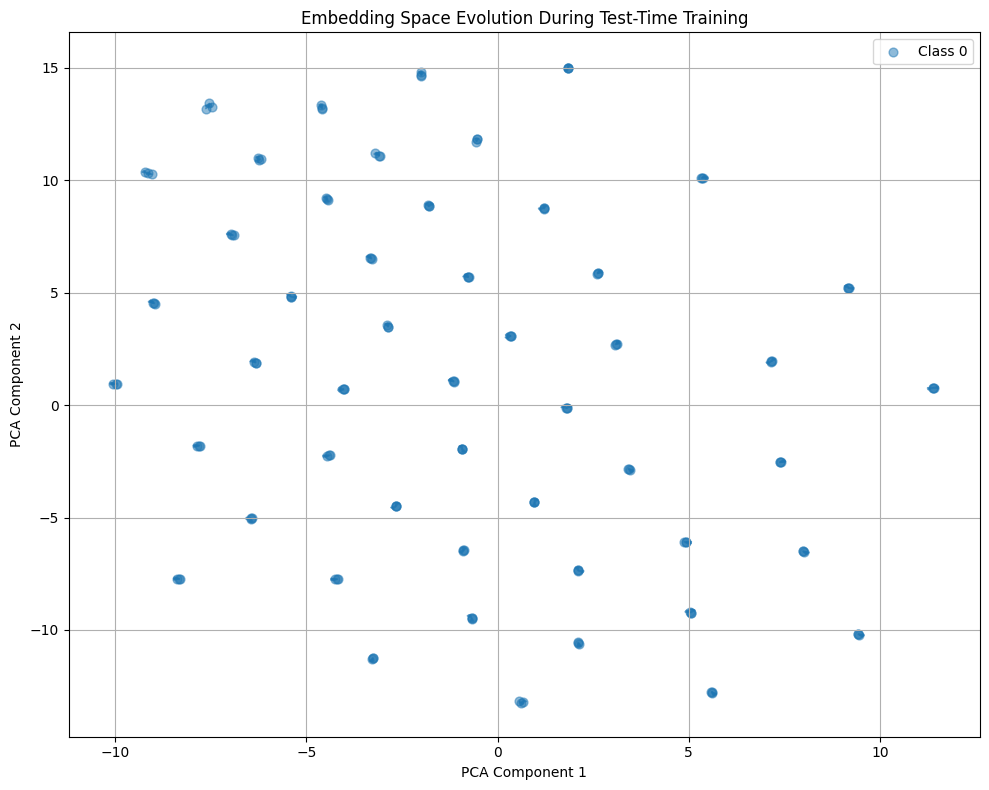

In [52]:
visualize_embedding_evolution(flatenned_embeddings_list, labels, method='t-SNE')

/Users/samsongourevitch/Documents/MVA_RecVis_TTT/test_time_training_mae/myenv/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


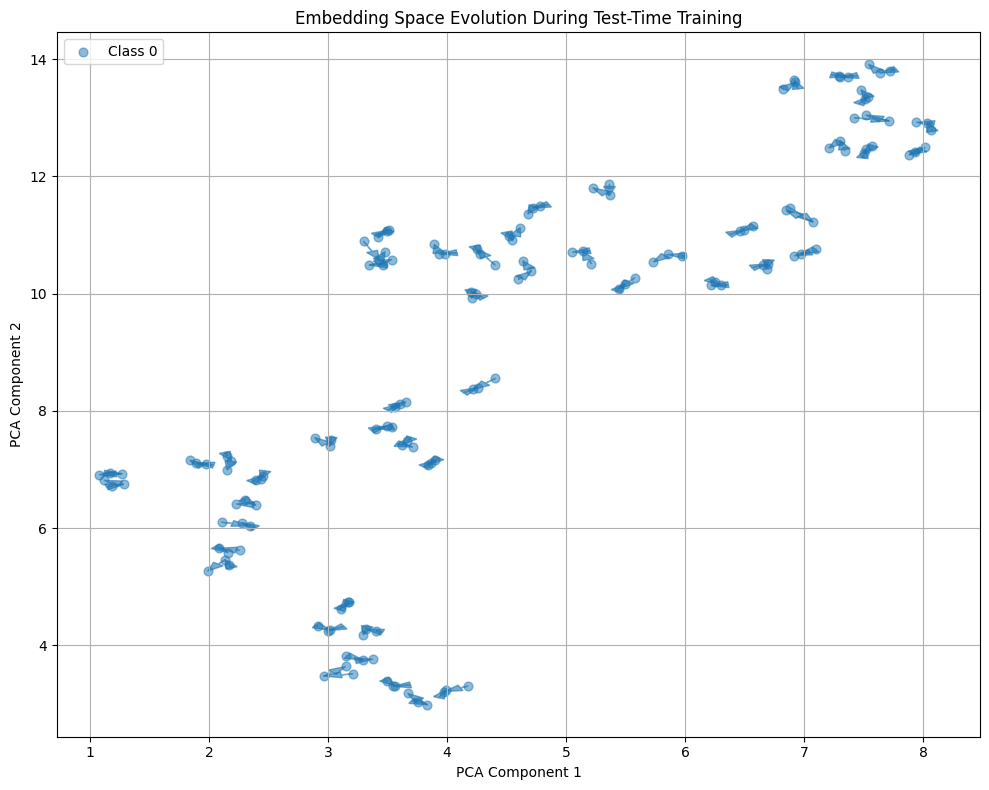

In [55]:
visualize_embedding_evolution(pooled_embeddings_list, labels, method='UMAP'